# Substructures & substructure filters

In addition to the descriptors introduced in the previous notebooks, determining whether a given chemical structure contains specific substructures or structural patterns can provide additional ways to characterize a set of structures, and filter it if desired. Also, substructure search is a core feature in most chemical databases. When you prepare chemical databases of your own, you should definitely consider implementing it :)

Now, for our usual boilerplate:

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv

RDKit WARNING: [10:39:39] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# load your own set, and DrugBank :)
with open('../data/chembl_mtor_ic50.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    mtor_ligands = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

## Basic substruct search

The simplest use of this concept is to determine whether a given chemical structure contains a given substructure. Substructure patterns can be defined using [SMARTS notation](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html), which is kind of like a [regular expression](https://en.wikipedia.org/wiki/Regular_expression) for chemical structures, i.e. SMARTS are to SMILES what regex are to strings. The materials provided as part of the actual lectures will probably have more theory about SMARTS, substructure search in general, as well as the underlying [graph theory aspects](https://en.wikipedia.org/wiki/Subgraph_isomorphism_problem). For some more applied info, the [RDKit intro](https://www.rdkit.org/docs/GettingStartedInPython.html) and [RDKit Book](https://www.rdkit.org/docs/RDKit_Book.html) go into good detail about substructure search.

Let's try some substructures. How about ethanol-like C-C-O?

In [3]:
# SMARTS-based chemical substructures are instantiated much like the standard SMILES-based mol instances:
ethanol_pattern = Chem.MolFromSmarts('CCO')
# and test our first substruct search

propanol = Chem.MolFromSmiles('CCCO') # a direct superstructure of ethanol
propanol.HasSubstructMatch(ethanol_pattern)

True

In [4]:
# now for something definitely without the CCO substructure
toluene = Chem.MolFromSmiles('Cc1ccccc1')
toluene.HasSubstructMatch(ethanol_pattern)

False

In [5]:
# any matches of the ethanol subgraphs count
# including the CCO in CC(O)OH group of carboxylic acids
citric_acid = Chem.MolFromSmiles('OC(=O)CC(O)(C(=O)O)CC(=O)O')
citric_acid.HasSubstructMatch(ethanol_pattern)

True

In [7]:
# The RDKit functionality also goes well beyond the basic binary does/doesn't match.
# Function GetSubstructMatch will get indices of all matching atoms and bonds
# within the target molecule
import itertools # for getting combinations without having to write additional function
hit_atoms = propanol.GetSubstructMatch(ethanol_pattern) # indices of matching atoms
hit_bonds = [propanol.GetBondBetweenAtoms(i, j).GetIdx()
             for i, j in itertools.combinations(hit_atoms, 2)
             if propanol.GetBondBetweenAtoms(i, j)]
hit_atoms, hit_bonds

((1, 2, 3), [1, 2])

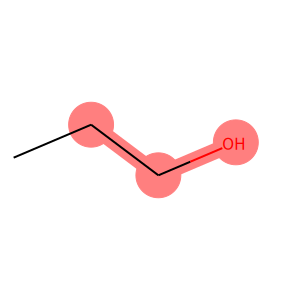

In [8]:
# so the hit matches atoms with IDs 1, 2, 3 and bonds with IDs 1 and 2
# we can even visualize the hits by coloring the hit atoms and bonds
# we will need few more fancy libraries though
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
d = rdMolDraw2D.MolDraw2DSVG(300,300)
rdMolDraw2D.PrepareAndDrawMolecule(d, propanol, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
d.FinishDrawing()
display(SVG(d.GetDrawingText()))

That's CCO within CCCO, looks about right :) Let's formalize this visualization into a copypastable function that works on mutiple matches, maybe it will come in handy sometime later:

In [9]:
import itertools
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def visualize_match(structure, pattern):
    # GetSubstructMatches grabs all hits, GetSubstructMatch the first one it finds
    hits = structure.GetSubstructMatches(pattern)
    hit_atoms = set()
    hit_bonds = set()
    for hit in hits:
        hit_atoms.update(hit)
        hit_bonds.update([structure.GetBondBetweenAtoms(i, j).GetIdx()
                          for i, j in itertools.combinations(hit_atoms, 2)
                          if structure.GetBondBetweenAtoms(i, j)])
    d = rdMolDraw2D.MolDraw2DSVG(300,300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, structure, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

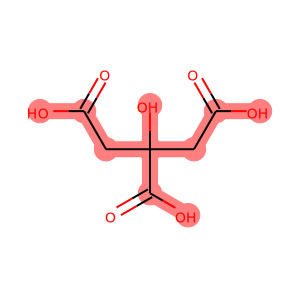

In [10]:
# let's test it out on our citric acid and ethanol patterns:
visualize_match(citric_acid, ethanol_pattern)

Looks legit. How about something more practical, like COOH groups?

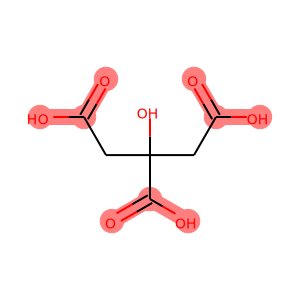

In [11]:
cooh_pattern = Chem.MolFromSmarts('C(=O)[O;h1]')
# means C (double bond to O on a sidechain) O with one implicit hydrogen
visualize_match(citric_acid, cooh_pattern)

Now, let's have a look how many structures with COOH groups are in our MTOR ligand set, and how many in DrugBank:

In [12]:
cooh_counts_mtor = [len(m.GetSubstructMatches(cooh_pattern)) for m in mtor_ligands]
cooh_counts_mtor_nonzero = [m for m in cooh_counts_mtor if m]
len(cooh_counts_mtor), len(cooh_counts_mtor_nonzero), sum(cooh_counts_mtor_nonzero)/len(cooh_counts_mtor_nonzero)

(4596, 24, 1.0)

So, from our 4596 MTOR ligands, only 24 structures have the COOH group, and the exact average is one - meaning they all have only one COOH group. Let's have a look at DrugBank:

In [13]:
cooh_counts_drugbank = [len(m.GetSubstructMatches(cooh_pattern)) for m in drugs]
cooh_counts_drugbank_nonzero = [m for m in cooh_counts_drugbank if m]
len(cooh_counts_drugbank), len(cooh_counts_drugbank_nonzero),\
sum(cooh_counts_drugbank_nonzero)/len(cooh_counts_drugbank_nonzero),\
max(cooh_counts_drugbank_nonzero)

(7113, 1635, 1.2574923547400612, 8)

Apparently, COOH group is much more common in DrugBank, and quite a few structures from DrugBank have more than a single COOH group. There is at least one with 8 COOH groups, let's have a look at it:

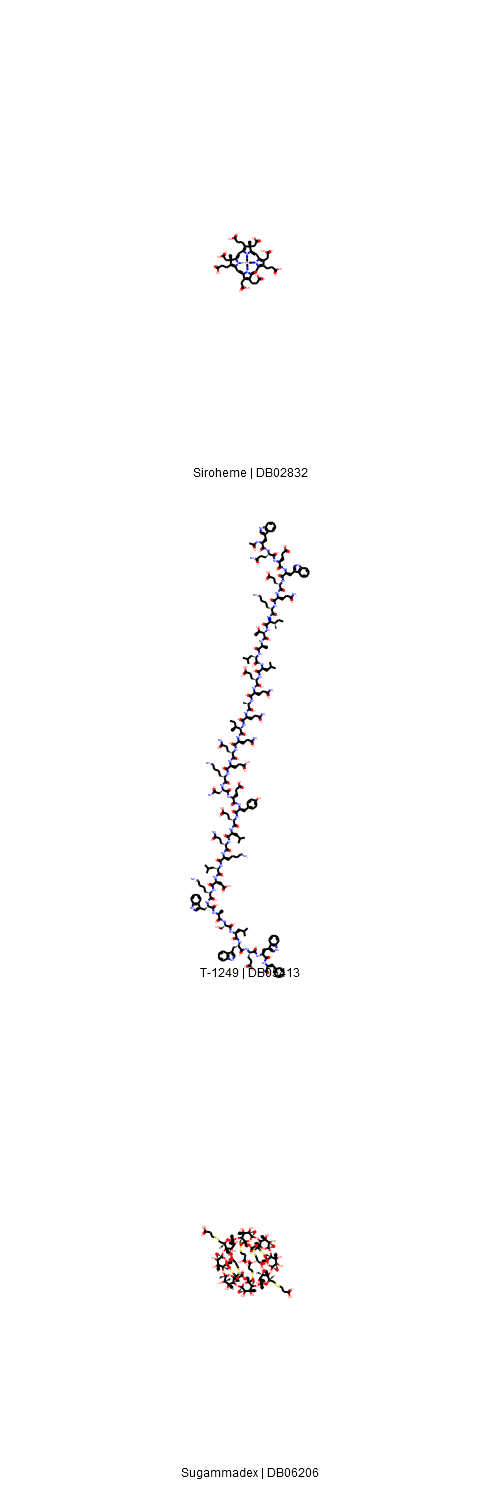

In [14]:
lots_of_cooh = [m for m, i in zip(drugs, cooh_counts_drugbank) if i == 8]
Draw.MolsToGridImage(lots_of_cooh, molsPerRow=1, subImgSize=(500,500),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in lots_of_cooh])

So, an experimental [organometallic](https://www.drugbank.ca/drugs/DB02832) thing, an [oligopeptide-like monster](https://www.drugbank.ca/drugs/DB05413) developed against HIV and a [very polycyclic](https://www.drugbank.ca/drugs/DB06206) approved selective muscle relaxant. At least the latter two probably have to be injected.

Let's make a less generic DrugBank query:

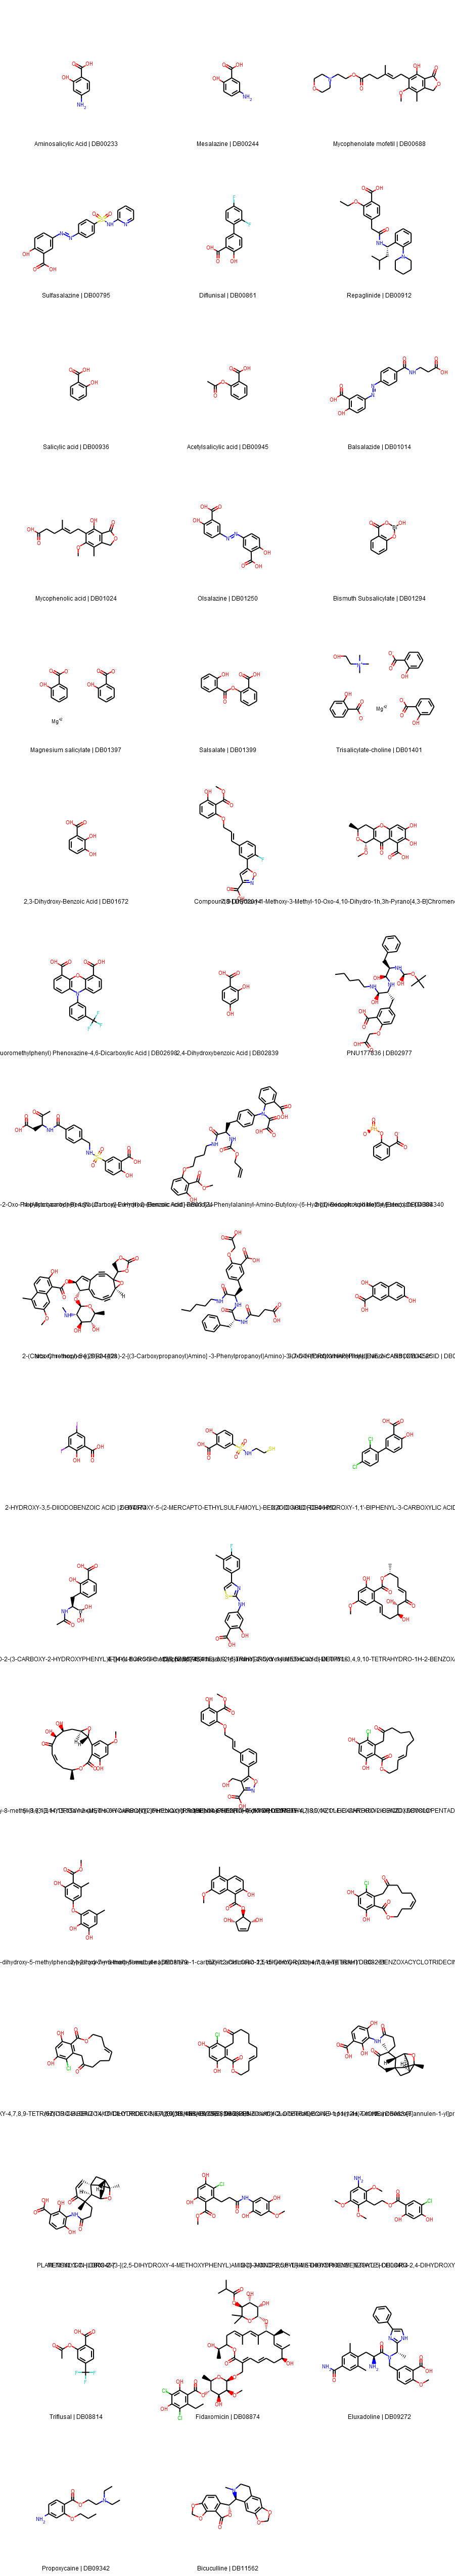

In [15]:
salicylic_acid_pattern = Chem.MolFromSmarts('c1ccc(c(c1)C(=O)O)O')
# get all salicylic acid derivates from DrugBank
drugbank_salicylics = [m for m in drugs if m.HasSubstructMatch(salicylic_acid_pattern)]
Draw.MolsToGridImage(drugbank_salicylics, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in drugbank_salicylics])

There seem to be quite a few structures in DrugBank that contain salicylic acid substructure, including salicylic acid itself. The searched parrents can get as complex as you want them to:

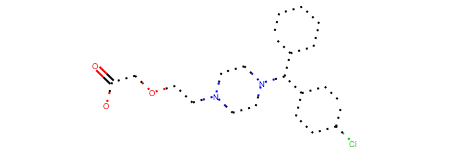

In [16]:
cetirizine_pattern = Chem.MolFromSmarts('Clc1ccc(cc1)C(c2ccccc2)N3CCN(CC3)CCOCC(=O)O')
cetirizine_pattern

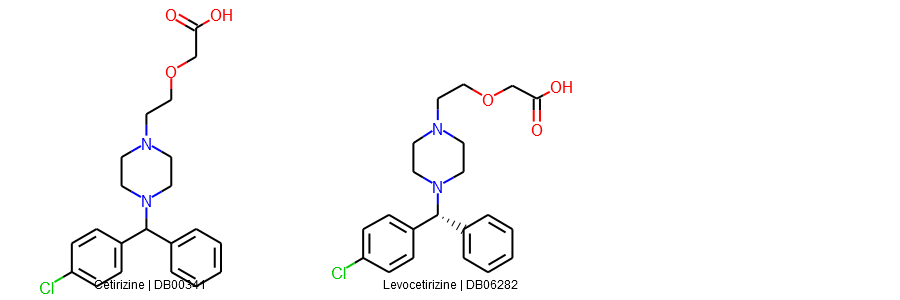

In [17]:
drugbank_cetirizine = [m for m in drugs if m.HasSubstructMatch(cetirizine_pattern)]
Draw.MolsToGridImage(drugbank_cetirizine, molsPerRow=3, subImgSize=(300,300),
                     legends=["{} | {}".format(m.GetProp('GENERIC_NAME'), m.GetProp('DRUGBANK_ID'))
                              for m in drugbank_cetirizine])

Cetirizine is one of the popular antiallergic drugs, a H1 antagonist. The query found not only the cetirizine itself (racemic), but also its specific stereo form, levocetirizine. This is a typical [chiral switch](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3777548/#s004title), where a generic substance is registered anew under a specific stereo form. Same mechanism, same base structure, brand new patent :)

# PAINS
In addition to our custom queries, there are also established lists of substructures put together for a specific purpose. Widely used, and widely discussed are the PAINS, or [PAn -Assay INterference compoundS](https://www.nature.com/news/chemistry-chemical-con-artists-foil-drug-discovery-1.15991). These are structural patterns that are known to interfere with the mechanism of assays used to screen for substances with a desired biological activity. These structures are likely to come up as false positivies in assays, and might become a trap that consumes time and resources of those unfamiliar with those factors. As always in cheminformatics, PAINS are not a panacea and should be used [with care](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5778390/). They are definitively red flags, though, and you should be definitely aware of them. As shown in the Nature article:

![PAINS](../data/pix/pains.jpg)
![PAINS2](../data/pix/pains2.jpg)

Let's load up some of those PAINS, and see whether your sets of ligands have any of them :)

In [18]:
from itertools import chain
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags
pains, len(pains)

([[<rdkit.Chem.rdchem.Mol at 0x23640058a30>, 'anil_di_alk_F(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640050e90>, 'hzone_anil(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058a80>, 'het_5_pyrazole_OH(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058b20>, 'het_thio_666_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058b70>, 'styrene_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058c10>, 'ne_rhod_C(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058cb0>, 'hp_amino_CN_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058d00>, 'cyano_imine_C(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058d50>, 'thio_urea_A(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058df0>, 'thiophene_amino_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058e90>, 'keto_keto_beta_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058ee0>, 'keto_phenone_A(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640058f80>, 'cyano_pyridone_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640053080>, 'thiaz_ene_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x23640053120>, 'hzone_thiophene

So, we have parsed over 400 known PAINS, in a list of (pattern, patternname) pairs. Let's scan our MTOR set, you process yours... substruct search is expensive, so it might take a while :)

In [19]:
for m in mtor_ligands: # for each ligand
    # add a variable that stores indices of all PAINS patterns that match it
    m.pain_hits = [i for i, pain in enumerate(pains) if m.HasSubstructMatch(pain[0])]

mtor_with_pains = [m for m in mtor_ligands if m.pain_hits]
mtor_with_pains

Apparently, there is one structure with PAINS among the KNOWN ligands. Let's have a closer look:

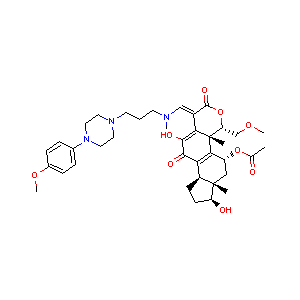

In [20]:
Draw.MolToImage(mtor_with_pains[0])

Looks like something large with a steroid-like core. What PAINS did it trigger?

In [21]:
mtor_with_pains[0].pain_hits, pains[mtor_with_pains[0].pain_hits[0]]

([418], [<rdkit.Chem.rdchem.Mol at 0x2363fcd0990>, 'anil_di_alk_C(246)'])

PAINS pattern with index 418, anil_di_alk_C, whatever that means?

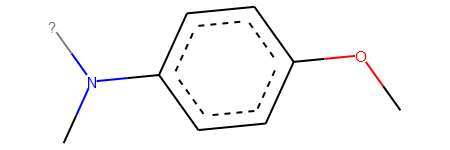

In [22]:
pains[mtor_with_pains[0].pain_hits[0]][0]

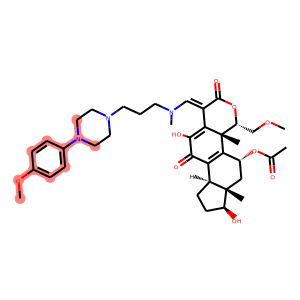

In [23]:
visualize_match(mtor_with_pains[0], pains[mtor_with_pains[0].pain_hits[0]][0])

That's the one. Apparently, this substructure is considered a PAINS according to [Eli Lilly](https://github.com/EliLillyCo/LillyMol/tree/master/contrib/data/query/PAINS). Since it is the only one in this ligand set, I would not hesitate with filtering this one structure away.

How do your ligand sets fare? Any PAINS, how many, which ones?

# What to do

 - again, load your own ligand set as well as DrugBank
 - try out the SMARTS-based substructure search on your own data
 - familiarize yourself with the notion of substructure search, if you haven't already from the lectures or other courses. Have a look at the linked resources.
 - Here, we tested our set and DrugBank for the -COOH functional group. Define your own SMARTS substructure, prefereably some functional group like -NH2, =O, etc. Run the substructure as a query on your own set, and against DrugBank. Any interesting outcome?
 - Have a look at PAINS. If you don't know them already, read up on the concept in the linked resources.
 - Scan your set for PAINS, have a look of how many of your structures have those substructures, and which ones. If you filter those structures out, how much would your set of structures shrink?
 - Bonus question: you might have noticed that extensive substructure searches take some time. Based on your experience and/or linked materials, any tips on why that might be? Any ideas on possible pre-filtering methods to speed things up?

In [31]:
import pandas as pd
h1_df = pd.read_csv('H1.csv', delimiter=';')
h1_df = h1_df[h1_df['Smiles'].isna() == False]
h1_ligands = list()

# Get RDKit Mol instances
for i in h1_df['Smiles']:
    h1_ligands.append(Chem.MolFromSmiles(i))

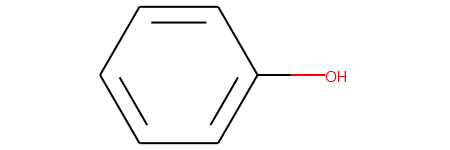

In [29]:
chlorbenzene = Chem.MolFromSmiles('[OH]c1ccccc1')
chlorbenzene

In [33]:
chlorbenzene_counts_h1 = [len(m.GetSubstructMatches(chlorbenzene)) for m in h1_ligands]
chlorbenzene_counts_h1_nonzero = [m for m in chlorbenzene_counts_h1 if m]
len(chlorbenzene_counts_h1), len(chlorbenzene_counts_h1_nonzero), sum(chlorbenzene_counts_h1_nonzero)/len(chlorbenzene_counts_h1_nonzero)

(1249, 372, 1.9408602150537635)

From 1249 H1 ligands, 372 structures have the chlorbenzene as their substructure, and the exact average is 1.94 - meaning they all have almost 2 chlorbenzene subgroups. This is not surprising as chlorbenzene is typically found in substructure of most antihistaminics. 

In [35]:
for m in h1_ligands: 
    m.pain_hits = [i for i, pain in enumerate(pains) if m.HasSubstructMatch(pain[0])]

h1_with_pains = [m for m in h1_ligands if m.pain_hits]
len(h1_with_pains)

29

Looks like 29 of my ligands contain PAINS substructure :(. However, it is not such a high number in total 1249 so we might as well exclude them.

Let's take one of them and see which PAINS subgroup it contains exactly. 

In [39]:
h1_with_pains[1].pain_hits, pains[h1_with_pains[1].pain_hits[0]]

([419], [<rdkit.Chem.rdchem.Mol at 0x2363fcd09e0>, 'ne_rhod_A(235)'])

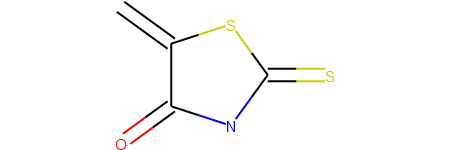

In [40]:
pains[h1_with_pains[1].pain_hits[0]][0]

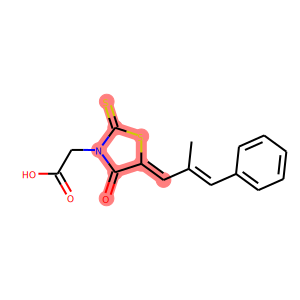

In [41]:
visualize_match(h1_with_pains[1], pains[h1_with_pains[1].pain_hits[0]][0])

There you are, bad boy! 

This was kinda fun, let's see another one:

In [53]:
h1_with_pains[28].pain_hits, pains[h1_with_pains[28].pain_hits[0]]

([4], [<rdkit.Chem.rdchem.Mol at 0x23640058b70>, 'styrene_A(13)'])

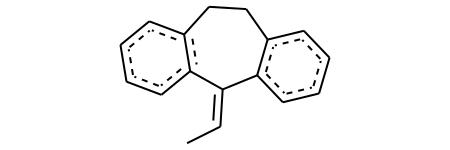

In [54]:
pains[h1_with_pains[28].pain_hits[0]][0]

What a lovely substructure.

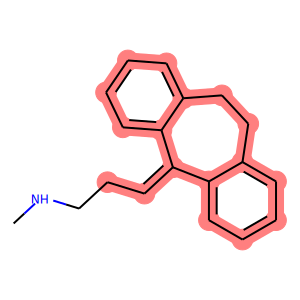

In [55]:
visualize_match(h1_with_pains[28], pains[h1_with_pains[28].pain_hits[0]][0])